In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

2022-04-24 13:33:13.487461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-24 13:33:13.487483: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [4]:
dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')

84140032/84125825 [==============================] - 39s 0us/step


In [5]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [6]:
os.listdir(dataset_dir)

['README', 'imdbEr.txt', 'train', 'test', 'imdb.vocab']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')

In [8]:
train_dir

'./aclImdb/train'

In [9]:
os.listdir(train_dir)

['urls_neg.txt',
 'urls_pos.txt',
 'pos',
 'unsupBow.feat',
 'neg',
 'labeledBow.feat',
 'urls_unsup.txt',
 'unsup']

In [10]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [11]:
sample_review_txt_file = os.path.join(train_dir, 'pos/1181_9.txt')

In [12]:
with open(sample_review_txt_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [13]:
batch_size = 64
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.25, subset='training', seed=seed)

Found 25000 files belonging to 2 classes.
Using 18750 files for training.


2022-04-24 13:34:09.158138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-24 13:34:09.158167: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-24 13:34:09.158187: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ehzgenusys): /proc/driver/nvidia/version does not exist
2022-04-24 13:34:09.159548: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# for text_batch, label_batch in raw_train_ds.take(1):
#     for i in range(5):
#         print("Review", text_batch.numpy()[i])
#         print("Label", label_batch.numpy()[i])

In [15]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [16]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.25, subset='training', seed=seed)

Found 25000 files belonging to 2 classes.
Using 18750 files for training.


In [17]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [18]:
def remove_br_tag(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    punc_less_text = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
    return punc_less_text

In [19]:
tf.print(remove_br_tag('I love Johny, <br />, but, <br /> Johny loves Omer.'))

i love johny   but   johny loves omer


In [20]:
tf.print(remove_br_tag)

<function remove_br_tag at 0x7f6d3c926440>


In [21]:
max_features = 10000
sequence_length = 250

In [22]:
vectorize_layer = layers.TextVectorization(standardize=remove_br_tag, max_tokens=max_features, output_mode='int', output_sequence_length=sequence_length)

In [23]:
vectorize_layer

In [24]:
# We do not want label
train_text = raw_train_ds.map(lambda x, y: x)

In [25]:
train_text

<MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [26]:
vectorize_layer.adapt(train_text)

In [27]:
# See the result of using this layer to preprocess some data
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [28]:
# retrive a batch (of 32 reviews and labels) from the dataset because recall, we set the batch size = 32
text_batch, label_batch = next(iter(raw_train_ds))

In [29]:
first_review, first_label = text_batch[0], label_batch[0]
last_review, last_label = text_batch[31], label_batch[31]

In [30]:
last_review

<tf.Tensor: shape=(), dtype=string, numpy=b"In order to rate this movie fairly you have to think about the genre it's supposed to be: children's. They had more guidelines to follow in order to make this movie (meaning it could not get away with some of the humor and or language from the 1st) taking all that in this movie was fun and enjoyable to watch. Sequels usually make me nervous, however this one did pretty well for itself. Knowing that it didn't have the star power of Fraiser as George they capitalized on the humor and i believe Showeman did pretty well as the lead. The plot being easy to follow and maybe campy at times fits well for a younger audience, if you want to watch a movie and hope for academy award honors this is not it, but if you want to watch a simple, fun, energy filled movie you would make a good choice with this one.">

In [31]:
print("review:", first_review)

review: tf.Tensor(b'I honestly had no idea that the Notorious B.I.G. (Bert I. Gordon the director; not the murdered rapper) was still active in the 80\'s! I always presumed the deliciously inept "Empire of the Ants" stood as his last masterful accomplishment in the horror genre, but that was before my dirty little hands stumbled upon an ancient and dusty VHS copy of "The Coming", a totally obscure and unheard of witchery-movie that actually turned out a more or less pleasant surprise! What starts out as a seemingly atmospheric tale of late Dark Ages soon takes a silly turn when a villager of year 1692 inexplicably becomes transferred to present day Salum, Massachusetts and promptly attacks a girl in the history museum. For you see, this particular girl is the reincarnation of Ann Putman who was a bona fide evil girl in 1692 and falsely accused over twenty people of practicing witchcraft which led to their executions at the state. The man who attacked Loreen lost his wife and daughter t

In [32]:
print("label", raw_train_ds.class_names[first_label])

label neg


In [33]:
print("Vectorized review:", vectorize_text(last_review, last_label))

Vectorized review: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   8,  659,    6, 1080,   11,   17, 1018,   22,   25,    6,  102,
          42,    2,  506,   29,  408,    6,   26, 2510,   34,   66,   50,
           1,    6,  811,    8,  659,    6,   96,   11,   17, 1193,    9,
          98,   21,   75,  238,   16,   46,    5,    2,  475,    3,   41,
        1066,   35,    2, 3291,  653,   31,   12,    8,   11,   17,   13,
         244,    3,  730,    6,  103, 2149,  611,   96,   69, 4366,  190,
          11,   28,  117,  178,   73,   15,  407, 1200,   12,    9,  152,
          25,    2,  324,  656,    5,    1,   14,  715,   34,    1,   20,
           2,  475,    3,   10,  258,    1,  117,  178,   73,   14,    2,
         485,    2,  112,  108,  762,    6,  811,    3,  277, 2843,   30,
         206, 2262,   73,   15,    4, 1160,  307,   45,   22,  179,    6,
         103,    4,   17,    3,  423,   15, 1742, 1352,    1,   11,    7,
          21,    9,   18,   45,   22,  179, 

In [34]:
print("Vectorized review:", vectorize_text(first_review, first_label))

Vectorized review: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10, 1201,   66,   58,  315,   12,    2, 2811,  199, 7082,   10,
        2292,    2,  171,   21,    2, 1937,    1,   13,  124, 5784,    8,
           2,  847,   10,  207,    1,    2, 6043, 2909, 3730,    5,    2,
        5186, 3138,   14,   24,  228, 4771, 8359,    8,    2,  193,  506,
          18,   12,   13,  153,   54, 1684,  111,  957, 5453,  716,   33,
        2218,    3, 9723, 1924, 1012,    5,    2,  579,    4,  470, 3678,
           3,    1,    5,    1,   12,  158,  709,   44,    4,   50,   41,
         323, 2049,  840,   48,  500,   44,   14,    4, 1513, 3006,  815,
           5,  537,  444, 2053,  524,  294,    4,  686,  456,   51,    4,
           1,    5,  336,    1, 4775,  454, 9293,    6, 1011,  254,    1,
           1,    3, 6185, 2645,    4,  247,    8,    2,  463, 5218,   15,
          22,   67,   11,  796,  247,    7,    2, 8645,    5, 2208,    1,
          36,   13,    4,    1,    1,  435, 

In [35]:
print("6 ---> ", vectorize_layer.get_vocabulary()[6])
print("1538 ---> ", vectorize_layer.get_vocabulary()[1538])
print("11 ---> ", vectorize_layer.get_vocabulary()[11])
print("1 ---> ", vectorize_layer.get_vocabulary()[1])
print("16 ---> ", vectorize_layer.get_vocabulary()[16])

print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

6 --->  to
1538 --->  compare
11 --->  this
1 --->  [UNK]
16 --->  with
Vocabulary size: 10000


In [36]:
print(np.array(first_review))

b'I honestly had no idea that the Notorious B.I.G. (Bert I. Gordon the director; not the murdered rapper) was still active in the 80\'s! I always presumed the deliciously inept "Empire of the Ants" stood as his last masterful accomplishment in the horror genre, but that was before my dirty little hands stumbled upon an ancient and dusty VHS copy of "The Coming", a totally obscure and unheard of witchery-movie that actually turned out a more or less pleasant surprise! What starts out as a seemingly atmospheric tale of late Dark Ages soon takes a silly turn when a villager of year 1692 inexplicably becomes transferred to present day Salum, Massachusetts and promptly attacks a girl in the history museum. For you see, this particular girl is the reincarnation of Ann Putman who was a bona fide evil girl in 1692 and falsely accused over twenty people of practicing witchcraft which led to their executions at the state. The man who attacked Loreen lost his wife and daughter this and wants his 

In [37]:
type(first_review)

tensorflow.python.framework.ops.EagerTensor

In [38]:
print(first_review)

tf.Tensor(b'I honestly had no idea that the Notorious B.I.G. (Bert I. Gordon the director; not the murdered rapper) was still active in the 80\'s! I always presumed the deliciously inept "Empire of the Ants" stood as his last masterful accomplishment in the horror genre, but that was before my dirty little hands stumbled upon an ancient and dusty VHS copy of "The Coming", a totally obscure and unheard of witchery-movie that actually turned out a more or less pleasant surprise! What starts out as a seemingly atmospheric tale of late Dark Ages soon takes a silly turn when a villager of year 1692 inexplicably becomes transferred to present day Salum, Massachusetts and promptly attacks a girl in the history museum. For you see, this particular girl is the reincarnation of Ann Putman who was a bona fide evil girl in 1692 and falsely accused over twenty people of practicing witchcraft which led to their executions at the state. The man who attacked Loreen lost his wife and daughter this and 

In [39]:
# Finalize the dataset
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [40]:
test_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [41]:
val_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [42]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [43]:
#optimization for a performant training process
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
embedding_dim = 16

In [45]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

In [46]:
model

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [48]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [49]:
epochs = 15

In [50]:
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
293/293 [==============================] - 4s 12ms/step - loss: 0.6827 - binary_accuracy: 0.6537 - val_loss: 0.6621 - val_binary_accuracy: 0.7639
Epoch 2/15
293/293 [==============================] - 2s 7ms/step - loss: 0.6290 - binary_accuracy: 0.7682 - val_loss: 0.5902 - val_binary_accuracy: 0.7902
Epoch 3/15
293/293 [==============================] - 2s 7ms/step - loss: 0.5558 - binary_accuracy: 0.8008 - val_loss: 0.5171 - val_binary_accuracy: 0.8225
Epoch 4/15
293/293 [==============================] - 2s 7ms/step - loss: 0.4894 - binary_accuracy: 0.8307 - val_loss: 0.4562 - val_binary_accuracy: 0.8490
Epoch 5/15
293/293 [==============================] - 3s 9ms/step - loss: 0.4351 - binary_accuracy: 0.8522 - val_loss: 0.4089 - val_binary_accuracy: 0.8626
Epoch 6/15
293/293 [==============================] - 3s 9ms/step - loss: 0.3944 - binary_accuracy: 0.8649 - val_loss: 0.3728 - val_binary_accuracy: 0.8719
Epoch 7/15
293/293 [==============================] - 3s 9ms/st

In [51]:
loss, accuracy = model.evaluate(test_ds)

391/391 [==============================] - 2s 4ms/step - loss: 0.3171 - binary_accuracy: 0.8713


In [52]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [53]:
len(history_dict)

4

In [54]:
acc = history_dict['binary_accuracy']

In [55]:
acc

[0.6537066698074341,
 0.7681599855422974,
 0.8008000254631042,
 0.8307200074195862,
 0.8521599769592285,
 0.8648533225059509,
 0.8736533522605896,
 0.8802666664123535,
 0.8856533169746399,
 0.8934400081634521,
 0.8970133066177368,
 0.9034666419029236,
 0.9077866673469543,
 0.9102399945259094,
 0.9158400297164917]

In [56]:
val_acc = history_dict['val_binary_accuracy']

In [57]:
val_acc

[0.7638933062553406,
 0.7901866436004639,
 0.8224533200263977,
 0.8490133285522461,
 0.862559974193573,
 0.8718933463096619,
 0.8794133067131042,
 0.885866641998291,
 0.892853319644928,
 0.8977066874504089,
 0.9033066630363464,
 0.9078933596611023,
 0.9128000140190125,
 0.916159987449646,
 0.9202133417129517]

In [58]:
loss = history_dict['loss']

In [59]:
loss

[0.6826909184455872,
 0.6290356516838074,
 0.5558154582977295,
 0.4893880784511566,
 0.43514201045036316,
 0.3944106101989746,
 0.36365756392478943,
 0.33810189366340637,
 0.31801143288612366,
 0.3010554313659668,
 0.2858952283859253,
 0.2726074159145355,
 0.26112857460975647,
 0.2507663667201996,
 0.23993997275829315]

In [60]:
val_loss = history_dict['val_loss']

In [61]:
val_loss

[0.6620550751686096,
 0.5901567935943604,
 0.5170685648918152,
 0.45616161823272705,
 0.4088669717311859,
 0.3728097975254059,
 0.3446415066719055,
 0.3219718337059021,
 0.3030399978160858,
 0.28690287470817566,
 0.2727910280227661,
 0.2603455185890198,
 0.24899627268314362,
 0.23870457708835602,
 0.22918963432312012]

In [62]:
# Plot the accuracy and loss
# Start counting from 1
epochs = range(1, len(acc) + 1)

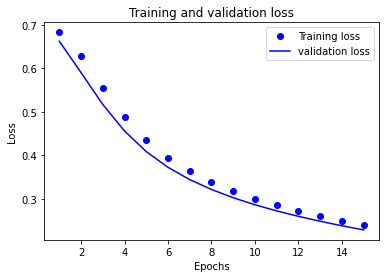

In [63]:
plt.plot(epochs, loss, 'bo', label='Training loss') # bo stands for "blue dot"
plt.plot(epochs, val_loss, 'b', label='validation loss') # b stands for "blue"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

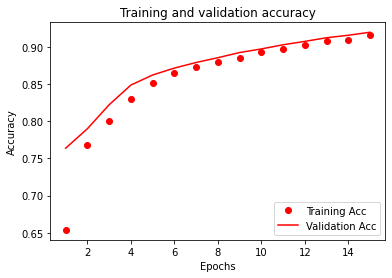

In [64]:
# Same plotting for the accuracy
plt.plot(epochs, acc, 'ro', label='Training Acc') # bo stands for "blue dot"
plt.plot(epochs, val_acc, 'r', label='Validation Acc') # b stands for "blue"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [65]:
# Export the model for the production use
Model_for_inference = tf.keras.Sequential([vectorize_layer, model, layers.Activation('sigmoid')])

In [66]:
Model_for_inference.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 sequential (Sequential)     (None, 1)                 160033    
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [68]:
Model_for_inference.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [69]:
Model_for_inference.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 sequential (Sequential)     (None, 1)                 160033    
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [74]:
examples = [
        "The movie was great!",
        "The movie was okay",
        "The movie was just trash",
        "The movie seems alright"
]

In [75]:
tf.print(examples)

['The movie was great!',
 'The movie was okay',
 'The movie was just trash',
 'The movie seems alright']


In [91]:
Model_for_inference.predict(examples)

array([[0.6019066 ],
       [0.43569624],
       [0.40394747],
       [0.41219026]], dtype=float32)

In [92]:
len(Model_for_inference.predict(examples))

4

In [93]:
Exlist = list(Model_for_inference.predict(examples))

In [94]:
def greater(x):
    if x >= 0.5:
        return 'positive'
    else:
        return 'negative'
    

In [95]:
greater(.6019066)

'positive'

In [96]:
type(Exlist[0])

numpy.ndarray

In [98]:
print(Exlist[0][0])

0.6019066


In [105]:

prediction_scores = []
prediction_classified = []
for row in Exlist:
    for val in row:
        prediction_scores.append(val)
        prediction_classified.append(greater(val))
        print(greater(val))
        

positive
negative
negative
negative


In [106]:
prediction_scores

[0.6019066, 0.43569624, 0.40394747, 0.41219026]

In [107]:
prediction_classified

['positive', 'negative', 'negative', 'negative']

In [110]:
for item in zip(examples, prediction_scores, prediction_classified):
    print(item)

('The movie was great!', 0.6019066, 'positive')
('The movie was okay', 0.43569624, 'negative')
('The movie was just trash', 0.40394747, 'negative')
('The movie seems alright', 0.41219026, 'negative')
